# A/B Testing Project 

# Introduction 

A/B Testing Analysis.

In this project, we focus on optimizing online store through rigorous A/B testing and data-driven decision-making. We have at our disposal three key datasets:

* Hypotheses Dataset: This dataset contains a list of hypotheses, each accompanied by ratings reflecting their potential impact and ease of implementation. These hypotheses represent opportunities for improvement or changes to our online store.
* Orders Dataset: The orders dataset provides detailed information about every transaction made on our online store, including transaction ID, user ID, and date of transaction. This dataset enables us to evaluate the impact of our A/B testing initiatives on actual user behavior and conversion rates.
* Visits Dataset: The visits dataset reveals insights into user engagement with our online store. By analyzing the count of visits by day, we gain a deeper understanding of user traffic patterns and behavior over time.

Our analysis unfolds in several stages:

* Prioritization of Hypotheses: We begin by prioritizing the hypotheses based on their ratings using two established frameworks: ICE (Impact, Confidence, Ease) and RICE (Reach, Impact, Confidence, Ease). This prioritization guides our focus towards the most impactful and feasible improvements.
* A/B Testing: With prioritized hypotheses in hand, we design and implement A/B tests to evaluate the effectiveness of various changes and enhancements. By comparing the performance of different variants, we assess their impact on key metrics such as conversion rates and user engagement.
* Analysis and Conclusion: Finally, we analyze the results of our A/B tests and draw conclusions based on the observed outcomes. Our ultimate goal is to determine whether to continue or cease the A/B testing initiatives. This decision is informed by a thorough assessment of the data and insights gathered throughout the analysis process.

This project represents a proactive approach to optimizing our online store, ensuring that we deliver the best possible user experience and drive sustainable growth in the competitive e-commerce landscape.

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
import math
from statsmodels.stats.proportion import proportions_ztest

## Preparing the data for analysis

### Hypotheses df

In [2]:
hypo = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')

In [3]:
hypo

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


The df has only 9 rows so we see that we don't have duplicates and missing values without checking by python methods.

### Orders df 

In [4]:
orders = pd.read_csv('/datasets/orders_us.csv')

In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [6]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [7]:
orders['date'].describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [8]:
orders.duplicated().value_counts()

False    1197
dtype: int64

In [9]:
orders.isna().value_counts()

transactionId  visitorId  date   revenue  group
False          False      False  False    False    1197
dtype: int64

We have no duplicates or missing values, and the datetime values are in the correct format.

In [10]:
A_group_count = orders[orders['group'] == 'A']['visitorId'].nunique()
print(A_group_count, " users in control group")
B_group_count = orders[orders['group'] == 'B']['visitorId'].nunique()
print(B_group_count, " users in test group")

503  users in control group
586  users in test group


In [11]:
A_inter = set(orders[orders['group'] == 'A']['visitorId'])
B_inter = set(orders[orders['group'] == 'B']['visitorId'])

intersection = A_inter.intersection(B_inter)
len(intersection)

58

In [12]:
orders[orders['visitorId'].isin(intersection)].sort_values(by='visitorId')

,transactionId,visitorId,date,revenue,group
703,4293855558,8300375,2019-08-07,30.5,A
71,3679129301,8300375,2019-08-01,165.7,B
823,2971973105,199603092,2019-08-27,45.9,A
246,437656952,199603092,2019-08-02,55.7,B
26,2223239646,199603092,2019-08-15,55.7,A
...,...,...,...,...,...
187,2048878902,4256040402,2019-08-17,25.8,A
114,1120327437,4256040402,2019-08-01,90.2,A
60,1421016313,4256040402,2019-08-16,875.5,B
662,1811671147,4266935830,2019-08-29,1220.2,A


We have users that are in both groups. We should drop them beacause we not sure which group they are.

In [13]:
new_orders = orders[~orders['visitorId'].isin(intersection)]
new_orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [14]:
A_group_count_new = new_orders[new_orders['group'] == 'A']['visitorId'].nunique()
print(A_group_count_new, " users in control group")
B_group_count_new = new_orders[new_orders['group'] == 'B']['visitorId'].nunique()
print(B_group_count_new, " users in test group")

445  users in control group
528  users in test group


### Visits df

In [15]:
visits = pd.read_csv('/datasets/visits_us.csv')

In [16]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [17]:
visits['date'] = visits['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [18]:
visits['date'].describe()

count                      62
unique                     31
top       2019-08-27 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Date columns are the same in both visits and orders datasets.

In [19]:
visits.duplicated().value_counts()

False    62
dtype: int64

In [20]:
visits.isna().value_counts()

date   group  visits
False  False  False     62
dtype: int64

We have no duplicates or missing values, and the datetime values are in the correct format.

**Conclusion on Data Preprocessing:**

We have three datasets at our disposal:

**Hypotheses Dataset:**
This dataset contains information regarding nine hypotheses that were subjected to testing. It includes the name of each hypothesis and its respective ratings for reach, impact, confidence, and effort, all rated on a scale from 1 to 10.

**Orders Dataset:**
The Orders dataset provides insights gained after conducting tests. It offers valuable data (Transaction ID, Visitor ID, Date of Transaction, Revenue and Group) that needs thorough analysis to draw meaningful conclusions.

**Visits Dataset:** 
Similar to the Orders dataset, the Visits dataset furnishes additional information gathered post-testing (Date of Visit, group and Count of Visits per Day), which warrants careful examination to derive comprehensive insights.

To ensure the accuracy of our A/B testing, we identified and removed users present in both control and test groups from our dataset. This step ensures unbiased results, allowing us to draw reliable conclusions from our analysis.

## Part 1. Prioritizing Hypotheses

In [21]:
pd.set_option('max_colwidth', 100)

In [22]:
hypo

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average...,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products ...,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


### ICE

In [23]:
hypo['ICE'] = (hypo['Impact'] * hypo['Confidence']) / hypo['Effort']

In [24]:
ice_hypo = hypo[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

In [25]:
ice_hypo

,Hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average...,7.000000
1,Launch your own delivery service. This will shorten delivery time,2.000000
5,Add a customer review page. This will increase the number of orders,1.333333
3,Change the category structure. This will increase conversion since users will find the products ...,1.125000
4,Change the background color on the main page. This will increase user engagement,1.000000


Hypothesis number eight, suggesting the launch of a promotion offering discounts to users, and hypothesis number zero, proposing the addition of two new channels for attracting traffic, have the highest ICE scores. On the other hand, hypothesis number four has the lowest score. Therefore, hypotheses indexed as eight and zero are the top priorities that require attention.

For a more comprehensive understanding, we will also prioritize hypotheses based on the RICE framework.

### RICE

In [26]:
hypo['RICE'] = (hypo['Reach'] * hypo['Impact'] * hypo['Confidence']) / hypo['Effort']

In [27]:
rice_hypo = hypo[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

In [28]:
rice_hypo

,Hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average...,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.2
3,Change the category structure. This will increase conversion since users will find the products ...,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


**CONCLUSION**

Despite initially prioritizing hypotheses based on the ICE framework, the RICE framework reveals a different perspective, facilitating a clearer decision-making process. While hypotheses indexed as eight and zero were initially favored due to their high ICE scores, the RICE analysis highlights the seventh hypothesis as having the highest potential for reaching a broader customer base. Additionally, it boasts a high confidence score, indicating a higher likelihood of success, with a moderate effort score suggesting it requires reasonable resources for testing. Furthermore, the impact rating for the seventh hypothesis is also high, suggesting that the proposed changes will be impactful.

After comparing the results from both ICE and RICE frameworks, it is determined that adding a subscription form to all main pages is likely to have a more positive impact on the conversion rate compared to other hypotheses. Conversely, both frameworks indicate that changing the background color on the main page is unlikely to yield significant improvements for the company.

Therefore, the decision is made to prioritize the implementation of the subscription form, leveraging insights from both ICE and RICE frameworks to inform strategic decision-making.

## Part 2. A/B Test Analysis

### Graph cumulative revenue by group

To make our analysis more informative and comfortable I'll construct cumulative data tables for both orders and visits, applying the techniques we've covered in our course.

In [29]:
new_orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [30]:
visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [31]:
dates_groups = new_orders[['date', 'group']].drop_duplicates()

In [32]:
orders_agg = dates_groups.apply(lambda x: new_orders[np.logical_and(new_orders['date'] <= x['date'],new_orders['group'] == x['group'] )].agg({'date':'max', 'group': 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue':'sum'}), axis=1).sort_values(by=['date','group'])

In [33]:
visits_agg = dates_groups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [34]:
data = orders_agg.merge(visits_agg, left_on=['date', 'group'], right_on=['date', 'group'])
data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [35]:
data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,74576.7,17708
58,2019-08-30,A,460,437,52363.7,18037
59,2019-08-30,B,531,511,77863.5,18198
60,2019-08-31,A,468,445,53212.0,18736


In [36]:
A = data[data['group']=='A'][['date','revenue', 'orders', 'visitors']]
B = data[data['group']=='B'][['date','revenue', 'orders', 'visitors']]

In [37]:
A

,date,revenue,orders,visitors
0,2019-08-01,2266.6,23,719
2,2019-08-02,3734.9,42,1338
4,2019-08-03,5550.1,66,1845
6,2019-08-04,6225.6,77,2562
8,2019-08-05,7623.6,99,3318
10,2019-08-06,8292.0,114,3985
12,2019-08-07,10234.0,130,4629
14,2019-08-08,11638.8,144,5239
16,2019-08-09,13734.0,155,5856
18,2019-08-10,16121.5,170,6262


In [38]:
B

,date,revenue,orders,visitors
1,2019-08-01,967.2,17,713
3,2019-08-02,3535.3,40,1294
5,2019-08-03,4606.9,54,1803
7,2019-08-04,6138.5,68,2573
9,2019-08-05,7587.8,89,3280
11,2019-08-06,10957.1,112,3935
13,2019-08-07,14392.7,135,4644
15,2019-08-08,16772.6,157,5298
17,2019-08-09,18428.8,176,5908
19,2019-08-10,20103.6,198,6277


Now I'll build the graph cumulative revenue by group

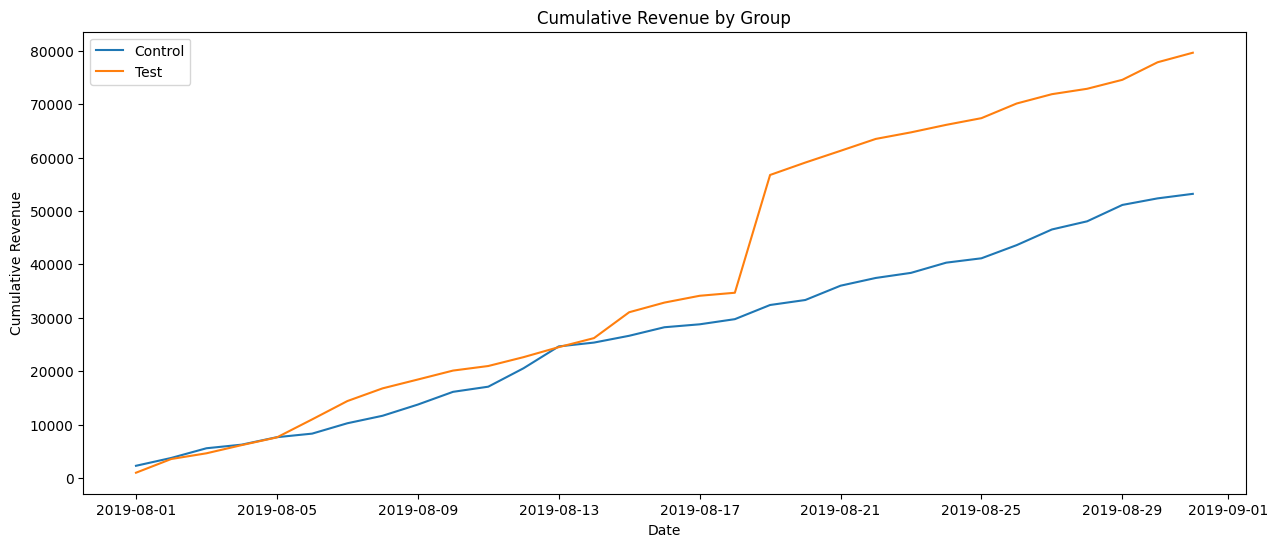

In [39]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(A['date'], A['revenue'], label='Control')
plt.plot(B['date'], B['revenue'], label='Test')
plt.title('Cumulative Revenue by Group')
plt.xlabel('Date')
plt.ylabel('Cumulative Revenue')
plt.legend()

Based on the graph, we observe a consistent increase in revenue over time for both groups. Additionally, there are instances where the revenue for group B surpasses that of group A, indicating the potential success of the modified version of the service. To validate these observations, we will employ additional analytical methods.

### Graph cumulative average order size by group.

In [40]:
A['cum_avg_order'] = A['revenue']/A['orders']
B['cum_avg_order'] = B['revenue']/B['orders']

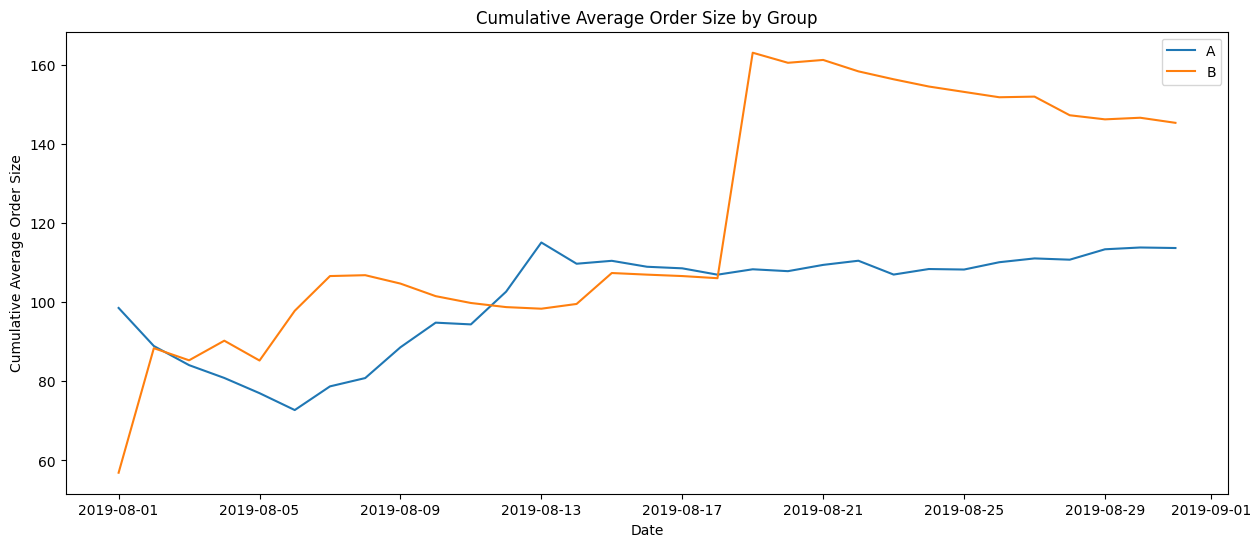

In [41]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(A['date'], A['cum_avg_order'], label='A')
plt.plot(B['date'], B['cum_avg_order'], label='B')
plt.title('Cumulative Average Order Size by Group')
plt.xlabel('Date')
plt.ylabel('Cumulative Average Order Size')
plt.legend()

Indeed, the graph illustrates specific instances where the average order size in group B experiences increase, but not a lot. This observation strengthens our conclusion drawn from the initial graph, indicating the success of the modified service, but we need to analyse this more because I don't see here notable difference between A and B group.

### Relative difference in cumulative average order size for group B compared with group A

In [42]:
AB = A.merge(B, on='date', suffixes=('_a', '_b'))

In [43]:
AB.head()

,date,revenue_a,orders_a,visitors_a,cum_avg_order_a,revenue_b,orders_b,visitors_b,cum_avg_order_b
0,2019-08-01,2266.6,23,719,98.547826,967.2,17,713,56.894118
1,2019-08-02,3734.9,42,1338,88.926190,3535.3,40,1294,88.382500
2,2019-08-03,5550.1,66,1845,84.092424,4606.9,54,1803,85.312963
3,2019-08-04,6225.6,77,2562,80.851948,6138.5,68,2573,90.272059
4,2019-08-05,7623.6,99,3318,77.006061,7587.8,89,3280,85.256180


In [44]:
AB['cum_avg_ord_dif'] = (AB['cum_avg_order_b'] / AB['cum_avg_order_a']) - 1

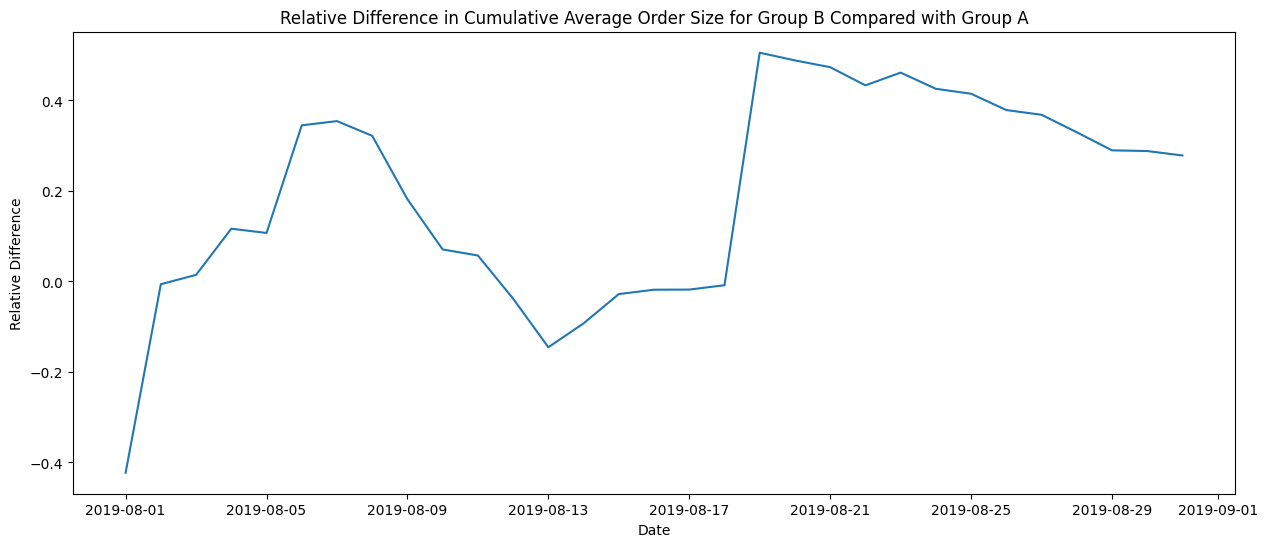

In [45]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(AB['date'], AB['cum_avg_ord_dif'])
plt.title('Relative Difference in Cumulative Average Order Size for Group B Compared with Group A')
plt.xlabel('Date')
plt.ylabel('Relative Difference')
plt.show()

If the Relative Difference is 0, it indicates that there is no difference between the Cumulative Average Order Sizes for Group A and Group B.

If the Relative Difference is less than 0, it suggests that the Cumulative Average Order Size for Group B is smaller than that of Group A.

At the beginning of the test, group A has greater cumulative average order sizes. However, as we progress through the graph, we notice fluctuations in the cumulative average order size of group B compared to group A. After August 17, 2019, we observe a notable increase in the Cumulative Average Order Sizes for Group B compared to Group A. These fluctuations suggest that the changes in the service being tested on group B may be influencing customer behavior, albeit the impact is not entirely clear. To gain further clarity, conducting additional testing would be advisable.

### Each group's conversion rate as the ratio of orders to the number of visits for each day.

In [46]:
AB.head()

,date,revenue_a,orders_a,visitors_a,cum_avg_order_a,revenue_b,orders_b,visitors_b,cum_avg_order_b,cum_avg_ord_dif
0,2019-08-01,2266.6,23,719,98.547826,967.2,17,713,56.894118,-0.422675
1,2019-08-02,3734.9,42,1338,88.926190,3535.3,40,1294,88.382500,-0.006114
2,2019-08-03,5550.1,66,1845,84.092424,4606.9,54,1803,85.312963,0.014514
3,2019-08-04,6225.6,77,2562,80.851948,6138.5,68,2573,90.272059,0.116511
4,2019-08-05,7623.6,99,3318,77.006061,7587.8,89,3280,85.256180,0.107136


In [47]:
AB['conversion_a'] = AB['orders_a']/AB['visitors_a']
AB['conversion_b'] = AB['orders_b']/AB['visitors_b']

In [48]:
AB

,date,revenue_a,orders_a,visitors_a,cum_avg_order_a,revenue_b,orders_b,visitors_b,cum_avg_order_b,cum_avg_ord_dif,conversion_a,conversion_b
0,2019-08-01,2266.6,23,719,98.547826,967.2,17,713,56.894118,-0.422675,0.031989,0.023843
1,2019-08-02,3734.9,42,1338,88.926190,3535.3,40,1294,88.382500,-0.006114,0.031390,0.030912
2,2019-08-03,5550.1,66,1845,84.092424,4606.9,54,1803,85.312963,0.014514,0.035772,0.029950
3,2019-08-04,6225.6,77,2562,80.851948,6138.5,68,2573,90.272059,0.116511,0.030055,0.026428
4,2019-08-05,7623.6,99,3318,77.006061,7587.8,89,3280,85.256180,0.107136,0.029837,0.027134
5,2019-08-06,8292.0,114,3985,72.736842,10957.1,112,3935,97.831250,0.345003,0.028607,0.028463
6,2019-08-07,10234.0,130,4629,78.723077,14392.7,135,4644,106.612593,0.354274,0.028084,0.029070
7,2019-08-08,11638.8,144,5239,80.825000,16772.6,157,5298,106.831847,0.321767,0.027486,0.029634
8,2019-08-09,13734.0,155,5856,88.606452,18428.8,176,5908,104.709091,0.181732,0.026469,0.029790
9,2019-08-10,16121.5,170,6262,94.832353,20103.6,198,6277,101.533333,0.070661,0.027148,0.031544


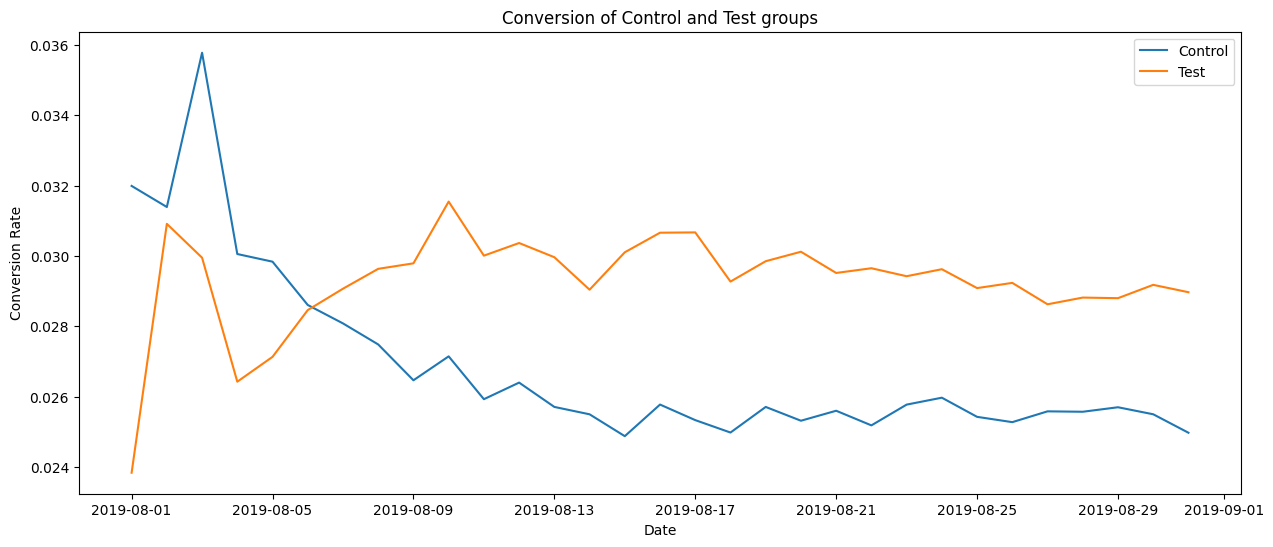

In [49]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(AB['date'], AB['conversion_a'], label='Control')
plt.plot(AB['date'], AB['conversion_b'], label='Test')
plt.title('Conversion of Control and Test groups')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend()

Based on the graph, we observe that in the beginning conversion rate of A group is higher but after that conversion rate of test group increases and keep higher till the end of the graph and conversion rate of control group decreases. It may tell us that applied business strategy is profitable

In [50]:
# overall conversion of control group
AB['orders_a'].sum()/AB['visitors_a'].sum()

0.02585769760495693

In [51]:
# overall concersion of test group 
AB['orders_b'].sum()/AB['visitors_b'].sum()

0.02943091972438227

The difference between groups in overall conversion is really not notable.

### Number of orders per user

In [52]:
new_orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [53]:
order_per_user_A = new_orders[new_orders['group']=='A'].groupby('visitorId').agg({'transactionId':'nunique'}).sort_values(by='transactionId', ascending=False).reset_index()

In [54]:
order_per_user_A

,visitorId,transactionId
0,611059232,3
1,2108163459,3
2,2988190573,3
3,3908431265,3
4,3967698036,3
...,...,...
440,1402025725,1
441,1398592185,1
442,1388079388,1
443,1378148355,1


In [55]:
order_per_user_B = new_orders[new_orders['group']=='B'].groupby('visitorId').agg({'transactionId':'nunique'}).sort_values(by='transactionId', ascending=False).reset_index()

In [56]:
order_per_user_B

,visitorId,transactionId
0,2742574263,3
1,249864742,3
2,3935952912,2
3,2025197455,2
4,3332057097,2
...,...,...
523,1388838483,1
524,1387624577,1
525,1379151787,1
526,1377447894,1


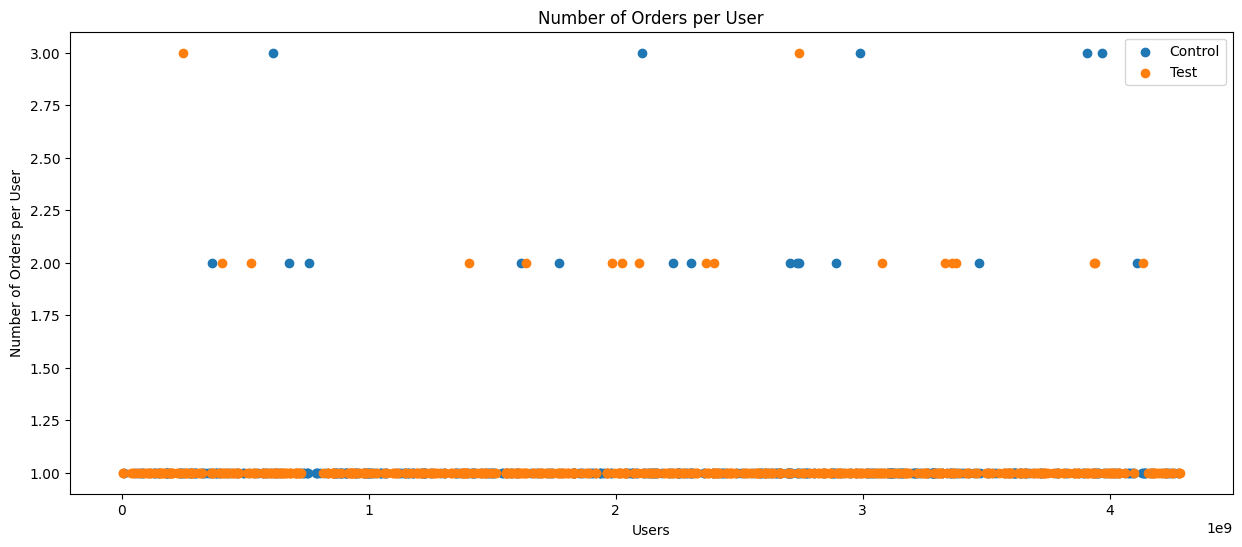

In [57]:
plt.scatter(order_per_user_A['visitorId'], order_per_user_A['transactionId'], label='Control')
plt.scatter(order_per_user_B['visitorId'], order_per_user_B['transactionId'], label='Test')
plt.title('Number of Orders per User')
plt.xlabel('Users')
plt.ylabel('Number of Orders per User')
plt.legend()

Each dot in scatterplot is individual user.

The scatterplot illustrates that there is no noticeable difference in the number of orders per user between the two groups.

### Anomalies in the count of orders per user

In [58]:
orders_anomaly_A = np.percentile(order_per_user_A['transactionId'], [95,99])
orders_anomaly_A

array([1.  , 2.56])

In [59]:
orders_anomaly_B = np.percentile(order_per_user_B['transactionId'], [95,99])
orders_anomaly_B

array([1., 2.])

Based on our calculations, we can conclude that the average user tends to make only a single purchase within costumer's lifetime. Instances where users place two or more orders are anomalies observed in both groups. Looks like the store sells something that average human buys only once. Maybe, wedding rings? ;)

### Order prices

In [60]:
new_orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [61]:
order_prices_A = new_orders[new_orders['group']=='A'].sort_values(by='revenue', ascending=False)

In [62]:
order_prices_B = new_orders[new_orders['group']=='B'].sort_values(by='revenue', ascending=False)

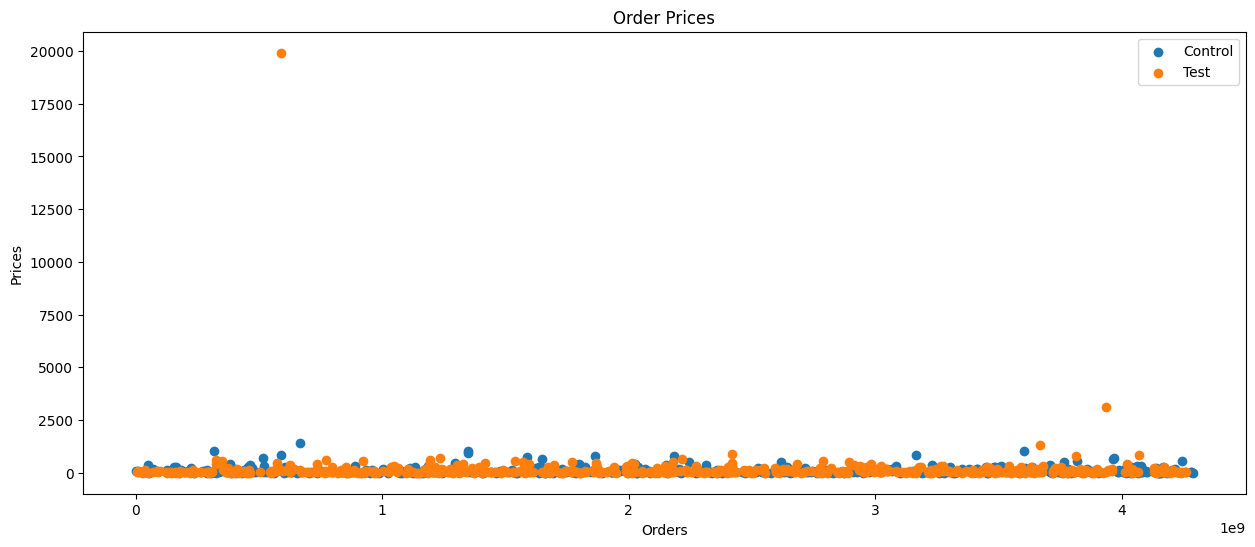

In [63]:
plt.scatter(order_prices_A['transactionId'], order_prices_A['revenue'], label='Control')
plt.scatter(order_prices_B['transactionId'], order_prices_B['revenue'], label='Test')
plt.title('Order Prices')
plt.xlabel('Orders')
plt.ylabel('Prices')
plt.legend()

Each dot in scatterplot is individual order.

While there appears to be no significant difference in order prices between the two groups, with the majority of purchases falling below 1000 according to the graph, it's noteworthy that a few orders from group B stand out with sums around 2500 and 20000. These instances could potentially be anomalies. Let's conduct further analysis to investigate these outliers and determine their impact on our findings.

let's limit the Y axis to see more detailed scatterplot.

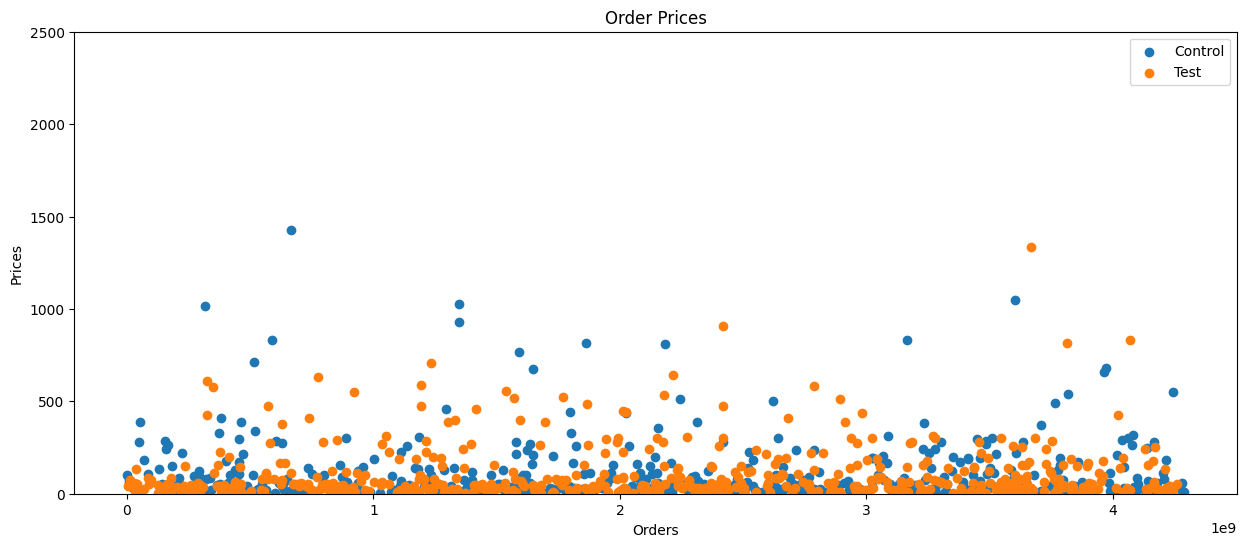

In [64]:
plt.scatter(order_prices_A['transactionId'], order_prices_A['revenue'], label='Control')
plt.scatter(order_prices_B['transactionId'], order_prices_B['revenue'], label='Test')
plt.title('Order Prices')
plt.xlabel('Orders')
plt.ylabel('Prices')
plt.ylim(0, 2500)
plt.legend()

I don't observe a notable difference in order size between the A and B groups. Here, we can see in more detail that the average order size ranges up to 500.

### Anomalies in the order prices

In [65]:
prices_anomaly_A = np.percentile(order_prices_A['revenue'], [95,99])
prices_anomaly_A

array([385.63 , 863.201])

In [66]:
prices_anomaly_B = np.percentile(order_prices_B['revenue'], [95,99])
prices_anomaly_B

array([425.795, 763.865])

The anomalies we observed in the graph may not have been detected using the percentile method because they likely fall below the first percentile threshold. Let's try to found them like this:

In [67]:
prices_anomaly_A = np.percentile(order_prices_A['revenue'], [99.5, 99.9, 99.99])
prices_anomaly_A

array([1022.4835 , 1250.3014 , 1408.25014])

In [68]:
prices_anomaly_B = np.percentile(order_prices_B['revenue'], [99.5, 99.9, 99.99])
prices_anomaly_B

array([ 1019.697  , 10730.6359 , 19001.42359])

We got them! So rare that don't even affect on the analysis.

But it is important to pay attention that anomalies from group B are bigger than anomalies from group A.

###  Statistical significance of the difference in conversion (in raw data)

In [69]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [70]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [71]:
# merging both df by date and group
orders_visits_merged = orders.merge(visits, on=['date', 'group'])

In [72]:
orders_visits_merged

,transactionId,visitorId,date,revenue,group,visits
0,3667963787,3312258926,2019-08-15,30.4,B,544
1,2804400009,3642806036,2019-08-15,15.2,B,544
2,3797467345,1196621759,2019-08-15,155.1,B,544
3,2282983706,2322279887,2019-08-15,40.5,B,544
4,182168103,935554773,2019-08-15,35.0,B,544
...,...,...,...,...,...,...
1192,2274188238,132143192,2019-08-14,15.5,A,735
1193,1692103379,1022829655,2019-08-14,5.7,A,735
1194,2203539145,370388673,2019-08-14,50.1,A,735
1195,1807773912,573423106,2019-08-14,165.3,A,735


In [73]:
# grouping new df in order to get unique visitors IDs by group and visits 
orders_visits_merged = orders_visits_merged.groupby(['group', 'visits', 'visitorId'], as_index=False).agg({'transactionId': pd.Series.nunique})

In [74]:
orders_visits_merged

,group,visits,visitorId,transactionId
0,A,361,343208965,1
1,A,361,787824685,1
2,A,361,1110543778,1
3,A,361,1460891116,1
4,A,361,1471496742,1
...,...,...,...,...
1165,B,770,3636663279,1
1166,B,770,3891541246,1
1167,B,770,3972127743,1
1168,B,770,4251087345,1


In [75]:
# aggregating df by number of unique visitors in order to find conversion rate 
orders_visits_merged.groupby(['group','visits']).agg({'visitorId':'nunique'}).reset_index()

,group,visits,visitorId
0,A,361,18
1,A,395,15
2,A,406,16
3,A,412,9
4,A,468,25
...,...,...,...
56,B,721,13
57,B,737,9
58,B,746,22
59,B,769,21


In [76]:
# splitting the data by group 
orders_visits_merged_A = orders_visits_merged[orders_visits_merged['group']=='A'].groupby('visits').agg({'visitorId':'nunique'}).reset_index()
orders_visits_merged_B = orders_visits_merged[orders_visits_merged['group']=='B'].groupby('visits').agg({'visitorId':'nunique'}).reset_index()

In [77]:
orders_visits_merged_A.head()

,visits,visitorId
0,361,18
1,395,15
2,406,16
3,412,9
4,468,25


In [78]:
orders_visits_merged_B.head()

,visits,visitorId
0,369,23
1,378,16
2,413,20
3,421,14
4,487,20


In [79]:
# Reviewer's code

reviewer_code = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
reviewer_code

,visitorId,transactionId
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1
...,...,...
498,4243832526,1
499,4256040402,7
500,4259830713,1
501,4266935830,1


In [80]:
reviewer_code[reviewer_code['transactionId'] == 0].value_counts()

Series([], dtype: int64)

In [81]:
reviewer_code[reviewer_code['visitorId'].isna()].count()

visitorId        0
transactionId    0
dtype: int64

In [82]:
# Calculating the total number of trials (visits) in the control group (Group A)
A_trials = orders_visits_merged_A['visits'].sum()
print("Control group trials:", A_trials)

# Calculating the total number of successes (number of user IDs that placed an order) in the control group (Group A)
A_successes = orders_visits_merged_A['visitorId'].sum()
print("Control group successes:", A_successes)

Control group trials: 18736
Control group successes: 543


In [83]:
# Calculating the total number of trials (visits) in the test group (Group B)
B_trials = orders_visits_merged_B['visits'].sum()
print("Test group trials:", B_trials)

# Calculating the total number of successes (number of user IDs that placed an order) in the test group (Group B)
B_successes = orders_visits_merged_B['visitorId'].sum()
print("Test group successes:", B_successes)

Test group trials: 18262
Test group successes: 627


In this statistical test we test statistical significance of the difference in conversion. As a parameters we will assign count of visits and count of orders by control and test groups. That is the actual proportions in the populations we're comparing (In this order: orders population A, visits population A, orders population B, visits population B). In the test we will get z-value that is the number of standard deviations a data point is from the mean of a dataset. If z-value is zero that mean that proportions were equal. If z-value is positive that indicates that the data point is above the mean. A negative z-value indicates that it's below the mean. But our goal is to test H0 or H1 hypotheses based on p-value (statistical difference of our proportions or in our case difference in conversions of control and test groups).

About hypotheses we test:

* H0 hypothesis (p-value greater than significance level) in our case mean that there is no statistical difference between proportions (between conversion rates of A and B groups).

* H1 hypothesis (p-value less than significance level) or in other words alternative hypothesis in our case mean that there is significant difference between proportions (between conversion rates of A and B groups).

In our A/B testing, we are interested in rejecting the null hypothesis (H0) in favor of the alternative hypothesis (H1) if we observe a statistically significant difference between the groups. This would indicate that the change introduced in the experimental group has had a measurable impact.

In [84]:
# Creating function for testing the Hypothesis that Proportions Are Equal and finding p-value after that.

# check_hypothesis function with trials and successes of control and test groups as parameters and alpha (significance level) 0.05 
def check_hypothesis(successes1, trials1, successes2, trials2, alpha=0.05):
    
    # Proportion of success in the first group (conversion rate in control group)
    p1 = successes1/trials1
    
    # proportion for success in the second group (conversion rate in test group)
    p2 = successes2/trials2
    
    # Combined proportion of conversion rates of two groups 
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # Difference in proportions
    difference = p1 - p2
    
    # calculating the statistic in standard deviations of the standard normal distribution (statistical formula)
    z_value = difference / math.sqrt(p_combined * (1-p_combined) * (1/trials1 + 1/trials2))
    
    # setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0,1)
    
    # Calculate p-value (getting the absolute value of the statistic using the abs() method)
    # Double the result because the result can be negative if the test is two-sided
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    # Printing the result in the necessary formar depending on the result of calculations
    print("z-value: ", z_value)
    print("p-value: ", p_value)
    if p_value<0.05:
        # If p_value less then significance level that means that there is strong evidence against the H0 hypothesis.
        # And we confirm H1 hypothesis that mean that there is significant difference between groups. 
        print("Reject H0. There is a significant difference between the proportions")
        
    else:
        # Else (p value greater than significance level) we can not reject H0 hypothesis and we don't have evidence in significant difference.
        print("FTR H0. There is no reason to consider the proportions different")

The same function we will use when we will work with filtered data.

In [85]:
# running the function with our A/B datasets parameters 
check_hypothesis(A_successes, A_trials, B_successes, B_trials, alpha=0.05)

z-value:  -2.9410980617466436
p-value:  0.003270509800141097
Reject H0. There is a significant difference between the proportions


Due to the results of the statistical test we can say that significance of the difference in conversion is really notable because statistical significance (0.0032) is lower than significance level (0.05 in our case). That mean that we rejected the null hypothesis (H0) in favor of the alternative hypothesis (H1) and possibility that the users come from the same population is less than 1% and we can say that the test performed very clear and any deviation in the test is not accidental. 

### Statistical significance of the difference in average order size (raw data)

In [86]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [87]:
# slicing the df by groups
orders_A = orders[orders['group'] == 'A']
orders_B = orders[orders['group'] == 'B']

In [88]:
# aggregating the df by count of transactions and sum of revenue in order to calculate average order size 
orders_A_daily = orders_A.groupby('date').agg({'transactionId':'count','revenue':'sum'}).reset_index()
orders_B_daily = orders_B.groupby('date').agg({'transactionId':'count','revenue':'sum'}).reset_index()

In [89]:
# calculating avg order size
orders_A_daily['avg_order_size_A'] = orders_A_daily['revenue'] / orders_A_daily['transactionId']
orders_B_daily['avg_order_size_B'] = orders_B_daily['revenue'] / orders_B_daily['transactionId']

In [90]:
# merging A and B group on date column 
orders_AB_daily = orders_A_daily.merge(orders_B_daily, on='date', suffixes=('_a', '_b'))

In [91]:
orders_AB_daily

,date,transactionId_a,revenue_a,avg_order_size_A,transactionId_b,revenue_b,avg_order_size_B
0,2019-08-01,24,2356.8,98.200000,21,1620.0,77.142857
1,2019-08-02,20,1503.5,75.175000,24,2623.8,109.325000
2,2019-08-03,24,1815.2,75.633333,16,1806.8,112.925000
3,2019-08-04,16,1146.6,71.662500,17,1717.3,101.017647
4,2019-08-05,25,1988.1,79.524000,23,1495.0,65.000000
5,2019-08-06,18,789.8,43.877778,28,3806.4,135.942857
6,2019-08-07,18,2242.9,124.605556,24,3531.5,147.145833
7,2019-08-08,16,1530.4,95.650000,27,3487.8,129.177778
8,2019-08-09,16,2947.1,184.193750,25,2558.1,102.324000
9,2019-08-10,16,3288.2,205.512500,23,1720.4,74.800000


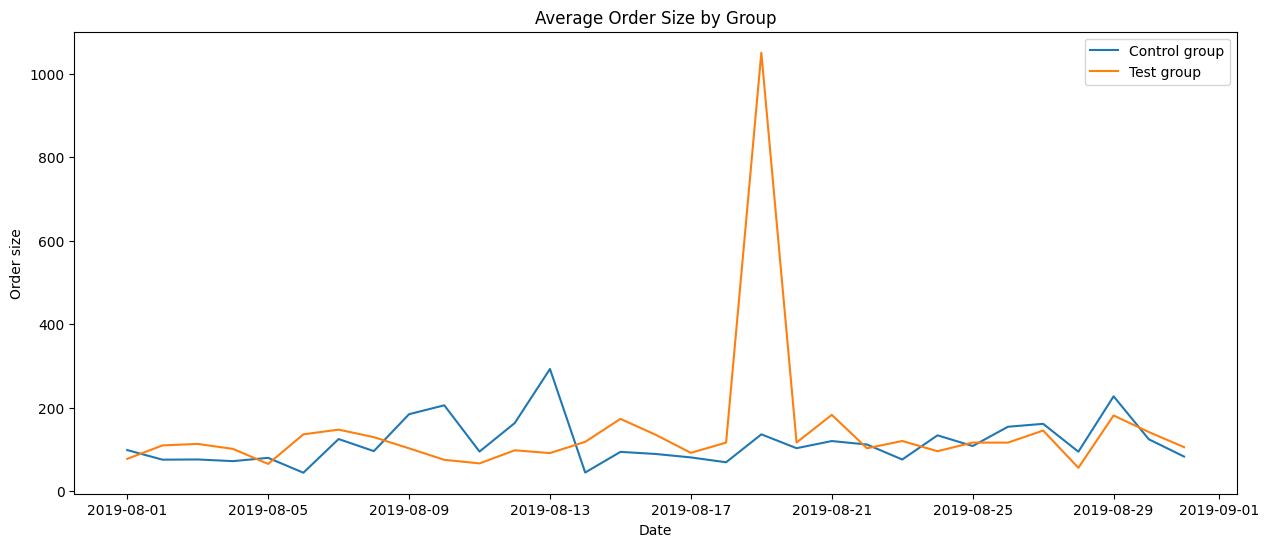

In [92]:
# creating a daily avg order size by group line plot
plt.plot(orders_AB_daily['date'], orders_AB_daily['avg_order_size_A'], label='Control group')
plt.plot(orders_AB_daily['date'], orders_AB_daily['avg_order_size_B'], label='Test group')
plt.title('Average Order Size by Group')
plt.xlabel('Date')
plt.ylabel('Order size')
plt.legend()

In this case we have an average data so we should conduct the Shapiro-Wilk test to determine if the distribution is normal. If the distribution is normal, we'll use the t-test; otherwise, we'll use the Wilcoxon-Mann-Whitney nonparametric test.

Due to the graph I see that distribution is abnormal but to be clear we'll do Shapiro-Wilk test.

In this test we also should check both H0 and H1 (alternative) hypothesis. Unlike of previous statistical test where we compared relations (retention rate) of two groups in this test we will need to compare distributions of average order size of contro; and test group:

    1) H0 hypothesis. If the distribution of average order size by day in both groups will be the same so we'll confirm H0 hypothesis that mean that there are no significant diferense in average order size disttribution. How we will know that there is no significant diferense in distribution? p-value will be higher than significance level (0.05)
    2) H1 hypothesis. If we'll found out the difference while comparing the distributions (p-value is lower than significance level) so we'll have evidence against H0 hypothesis in in favor of the alternative hypothesis (H1)
    
In this test we also interested in H1 hypothesis confirmation.

In [93]:
# Here we creating the function that will test the normality of distribution and due to this will perform the necessary test.
# Levene's test for normal distribution and Mann-Whitney U test for abnormal distribution 
# This function we will also use on filtered data.

# Function testing_average with parameters from A and B group and alpha (significance level) 0.05 by default.
def testing_average(sample1, sample2, alpha=0.05):
    
    # Shapiro-Wilk test for distribution normality 
    stat1, p1_norm = st.shapiro(sample1)
    stat2, p2_norm = st.shapiro(sample2)
    
    # Checking if both samples are normally distributed
    if p1_norm > alpha and p2_norm > alpha:
        
        # If both samples are normally distributed, perform Levene's test for homogeneity of variances
        statslev,p_levene = st.levene(sample1,sample2)
        
        # Checking if the variances are equal (p-value from Levene's test > alpha)
        if p_levene<alpha:
            
            # If variances are not equal, perform t-test
            statist,p_value = st.ttest_ind(sample1, sample2, equal_var=False)
        else:
             # If one or both samples are not normally distributed, perform Mann-Whitney U test
            statist,p_value = st.ttest_ind(sample1, sample2, equal_var=True)
    else:
        statist,p_value = st.mannwhitneyu(sample1, sample2)
        
# printing p-value and description of result
    print("P-value is: ", p_value)
    if p_value<alpha:
        # If p_value less then significance level that means that there is strong evidence against the H0 hypothesis.
        # And we confirm H1 hypothesis that mean that there is significant difference between groups. 
        print('Reject H0. There is a significant difference between the distributions.')
        
    else:
        # Else (p value greater than significance level) we can not reject H0 hypothesis and we don't have evidence in significant difference.
        print('Fail to Reject H0. There is no reason to consider the distributions are different')

In [94]:
# using our function with average order size of each group from our df as parameters
testing_average(orders_AB_daily['avg_order_size_A'], orders_AB_daily['avg_order_size_B'], alpha=0.05)

P-value is:  0.4222761086468382
Fail to Reject H0. There is no reason to consider the distributions are different


Due to the test we can't say that there is statistical significance of the difference in average order size beacause possibility that the users come from the same population is really high. 

### Statistical significance of the difference in conversion between the groups using the filtered data

To obtain filtered data, we'll take our new_orders data and remove all anomalies from it.

* First anomaly - more than 2 orders per user.
* Second anomaly - order's price more than 413 for control group and 445 for test group.

In [95]:
new_orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [96]:
# filtering the df that we'll get only visitors with less than 2 orders
orders_new = new_orders.groupby('visitorId').filter(lambda x: x['transactionId'].count() < 2)

In [97]:
orders_new

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [98]:
# filtering the data so we'll get only orders with revenue less than 413 in A group
orders_new_A = orders_new[(orders_new['group'] == 'A') & 
                          orders_new.groupby('transactionId')['revenue'].transform('sum').lt(413)]

In [99]:
# filtering the data so we'll get only orders with revenue less than 445 in B group 
orders_new_B = orders_new[(orders_new['group'] == 'B') & 
                          orders_new.groupby('transactionId')['revenue'].transform('sum').lt(445)]

In [100]:
# concatinate the data so we'll get both A and B group in df 
new_data = pd.concat([orders_new_A, orders_new_B]).reset_index()

In [101]:
# merging new data and visits df
new_data_visits_merged = new_data.merge(visits, on=['date', 'group'])

In [102]:
new_data_visits_merged

,index,transactionId,visitorId,date,revenue,group,visits
0,7,2626614568,78758296,2019-08-15,20.1,A,628
1,8,1576988021,295230930,2019-08-15,215.9,A,628
2,10,3649131742,879864040,2019-08-15,65.7,A,628
3,12,2809384911,3213223594,2019-08-15,115.4,A,628
4,14,3859315276,1565034404,2019-08-15,170.9,A,628
...,...,...,...,...,...,...,...
886,1181,1303723408,3218863961,2019-08-14,390.5,B,746
887,1186,2116724386,2146711261,2019-08-14,240.6,B,746
888,1190,38478481,1197745035,2019-08-14,135.3,B,746
889,1191,3592955527,608641596,2019-08-14,255.7,B,746


In [103]:
# grouping new df in order to get unique visitors IDs by group and visits 
new_data_visits_merged = new_data_visits_merged.groupby(['group', 'visits', 'visitorId'], as_index=False).agg({'transactionId': pd.Series.nunique})

In [104]:
new_data_visits_merged

,group,visits,visitorId,transactionId
0,A,361,343208965,1
1,A,361,1110543778,1
2,A,361,1460891116,1
3,A,361,1471496742,1
4,A,361,1722579998,1
...,...,...,...,...
886,B,770,2370420350,1
887,B,770,2461709734,1
888,B,770,3636663279,1
889,B,770,4251087345,1


In [105]:
# aggregating df by number of unique visitors in order to find conversion rate 
new_data_visits_merged = new_data_visits_merged.groupby(['group','visits']).agg({'visitorId':'nunique'}).reset_index()
new_data_visits_merged

,group,visits,visitorId
0,A,361,17
1,A,395,12
2,A,406,13
3,A,412,4
4,A,468,20
...,...,...,...
56,B,721,11
57,B,737,7
58,B,746,13
59,B,769,18


In [106]:
# slicing the df by group
new_orders_visits_merged_A = new_data_visits_merged[new_data_visits_merged['group']=='A']
new_orders_visits_merged_B = new_data_visits_merged[new_data_visits_merged['group']=='B']

In [107]:
new_orders_visits_merged_A.head()

,group,visits,visitorId
0,A,361,17
1,A,395,12
2,A,406,13
3,A,412,4
4,A,468,20


In [108]:
new_orders_visits_merged_B.head()

,group,visits,visitorId
31,B,369,21
32,B,378,12
33,B,413,15
34,B,421,11
35,B,487,16


In [109]:
# Calculating the total number of trials (visits) in the control group (Group A)
A_trials_new = new_orders_visits_merged_A['visits'].sum()
print("Control group trials:", A_trials_new)

# Calculating the total number of successes (number of user IDs that placed an order) in the control group (Group A)
A_successes_new = new_orders_visits_merged_A['visitorId'].sum()
print("Control group successes:", A_successes_new)

Control group trials: 18736
Control group successes: 406


In [110]:
# Calculating the total number of trials (visits) in the test group (Group B)
B_trials_new = new_orders_visits_merged_B['visits'].sum()
print("Control group trials:", B_trials_new)

# Calculating the total number of successes (number of user IDs that placed an order) in the test group (Group B)
B_successes_new = new_orders_visits_merged_B['visitorId'].sum()
print("Control group successes:", B_successes_new)

Control group trials: 18262
Control group successes: 485


In this statistical test we also test statistical significance of the difference in conversion as we did on raw data but now the data is filtered so the result might be a bit different.

As a parameters we will assign count of visits and count of orders by control and test groups. That is the actual proportions in the populations we're comparing (In this order: orders population A, visits population A, orders population B, visits population B). In the test we will get z-value that is the number of standard deviations a data point is from the mean of a dataset. If z-value is zero that mean that proportions were equal. If z-value is positive that indicates that the data point is above the mean. A negative z-value indicates that it's below the mean. But our goal is to test H0 or H1 hypotheses based on p-value (statistical difference of our proportions or in our case difference in conversions of control and test groups).

About hypotheses we test:

* H0 hypothesis (p-value greater than significance level) in our case mean that there is no statistical difference between proportions (between conversion rates of A and B groups).

* H1 hypothesis (p-value less than significance level) or in other words alternative hypothesis in our case mean that there is significant difference between proportions (between conversion rates of A and B groups).

In our A/B testing, we are interested in rejecting the null hypothesis (H0) in favor of the alternative hypothesis (H1) if we observe a statistically significant difference between the groups. This would indicate that the change introduced in the experimental group has had a measurable impact.

In [111]:
# Testing the Hypothesis that Proportions Are Equal as we did it on raw data
# If p_value less then significance level that means that there is strong evidence against the H0 hypothesis.
# And we confirm H1 hypothesis that mean that there is significant difference between groups. 
# Else (p value greater than significance level) we can not reject H0 hypothesis and we don't have evidence in significant difference.
check_hypothesis(A_successes_new, A_trials_new, B_successes_new, B_trials_new, alpha=0.05)

z-value:  -3.0664150484060864
p-value:  0.0021664236016099014
Reject H0. There is a significant difference between the proportions


In the filtered data, we also observe a significant difference between the proportions and we see that z-value is a bit lower that in raw data.

### Statistical significance of the difference in average order size between the groups using the filtered data.

In [112]:
new_data.head()

,index,transactionId,visitorId,date,revenue,group
0,7,2626614568,78758296,2019-08-15,20.1,A
1,8,1576988021,295230930,2019-08-15,215.9,A
2,10,3649131742,879864040,2019-08-15,65.7,A
3,12,2809384911,3213223594,2019-08-15,115.4,A
4,14,3859315276,1565034404,2019-08-15,170.9,A


In [113]:
# slicing the df by groups 
orders_A_new = new_data[new_data['group'] == 'A']
orders_B_new = new_data[new_data['group'] == 'B']

In [114]:
# aggregating the df by count of transactions and sum of revenue in order to calculate average order size 
orders_A_daily_new = orders_A_new.groupby('date').agg({'transactionId':'count','revenue':'sum'}).reset_index()
orders_B_daily_new = orders_B_new.groupby('date').agg({'transactionId':'count','revenue':'sum'}).reset_index()

In [115]:
# calculating daily average order size by group
orders_A_daily_new['avg_order_size_A'] = orders_A_daily_new['revenue'] / orders_A_daily_new['transactionId']
orders_B_daily_new['avg_order_size_B'] = orders_B_daily_new['revenue'] / orders_B_daily_new['transactionId']

In [116]:
# merging two dfs
orders_AB_daily_new = orders_A_daily_new.merge(orders_B_daily_new, on='date', suffixes=('_a', '_b'))

In [117]:
orders_AB_daily_new

,date,transactionId_a,revenue_a,avg_order_size_A,transactionId_b,revenue_b,avg_order_size_B
0,2019-08-01,13,531.3,40.869231,17,967.2,56.894118
1,2019-08-02,15,762.2,50.813333,18,1366.7,75.927778
2,2019-08-03,24,1815.2,75.633333,14,1071.6,76.542857
3,2019-08-04,10,669.8,66.980000,11,845.6,76.872727
4,2019-08-05,20,1287.5,64.375000,21,1449.3,69.014286
5,2019-08-06,8,394.8,49.350000,19,2151.5,113.236842
6,2019-08-07,14,925.9,66.135714,20,1614.0,80.700000
7,2019-08-08,13,1389.2,106.861538,20,1358.7,67.935000
8,2019-08-09,9,1034.3,114.922222,18,1600.9,88.938889
9,2019-08-10,13,1031.4,79.338462,21,1229.5,58.547619


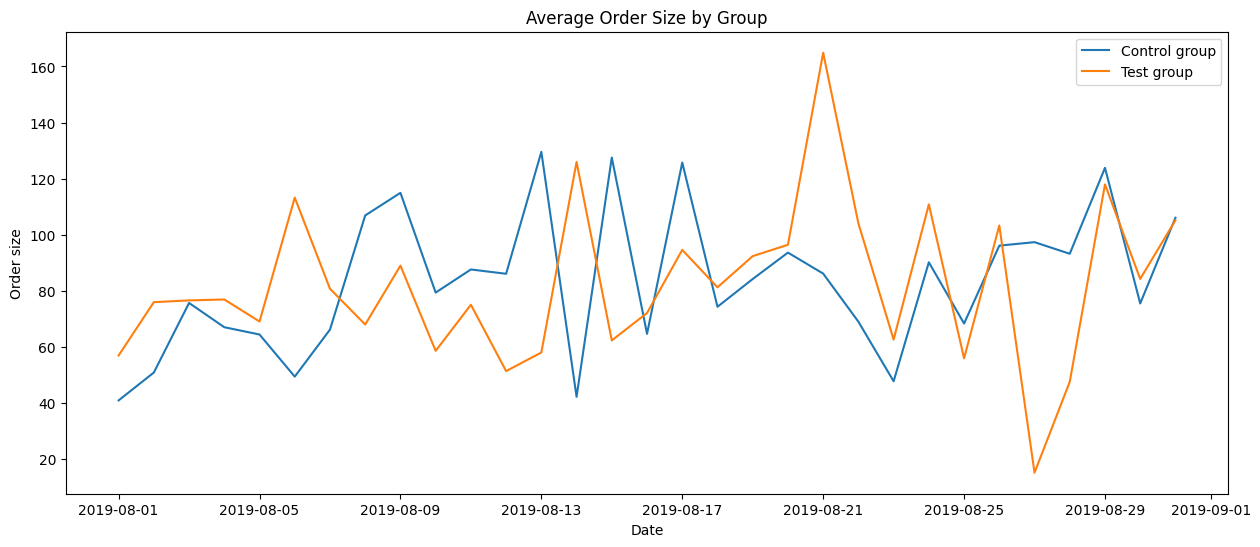

In [118]:
# building daily average order size by group line plot 
plt.plot(orders_AB_daily_new['date'], orders_AB_daily_new['avg_order_size_A'], label='Control group')
plt.plot(orders_AB_daily_new['date'], orders_AB_daily_new['avg_order_size_B'], label='Test group')
plt.title('Average Order Size by Group')
plt.xlabel('Date')
plt.ylabel('Order size')
plt.legend()

In this test we also should check both H0 and H1 (alternative) hypothesis as we did on raw data. And I remind that the test is differs from test where we found significant difference in conversion rate because in conversion rate we test significant difference of proportions and here we test the significant difference of distribution.  

    1) H0 hypothesis. If the distribution of average order size by day in both groups will be the same so we'll confirm H0 hypothesis that mean that there are no significant diferense in average order size disttribution. How we will know that there is no significant diferense in distribution? p-value will be higher than significance level (0.05)
    2) H1 hypothesis. If we'll found out the difference while comparing the distributions (p-value is lower than significance level) so we'll have evidence against H0 hypothesis in in favor of the alternative hypothesis (H1)
    
In this test we also interested in H1 hypothesis confirmation.

In [119]:
# using function that we used on raw data that checks normality of distribution and if variances are equal
# If p_value less then significance level that means that there is strong evidence against the H0 hypothesis.
# And we confirm H1 hypothesis that mean that there is significant difference between groups. 
# Else (p value greater than significance level) we can not reject H0 hypothesis and we don't have evidence in significant difference.
testing_average(orders_AB_daily_new['avg_order_size_A'], orders_AB_daily_new['avg_order_size_B'], alpha=0.05)

P-value is:  0.8557983331048568
Fail to Reject H0. There is no reason to consider the distributions are different


Due to the test on new data we also can't say that there is statistical significance of the difference in average order size beacause possibility that the users come from the same population even higher than in raw data.

# Conclusion

After a comprehensive analysis of the A/B testing results and the insights gathered from various analytical methods, it is evident that there are several key observations to consider:

The most prioritized hypothesis to test is "Add a subscription form to all the main pages."
Based on the revenue trend observed in the graph, both groups show a consistent increase over time, with instances of group B surpassing group A. This indicates the potential success of the modified service. However, further analysis is warranted to validate these observations.
While there are specific instances of an increase in average order size in group B, the overall difference between groups A and B is not significant. Additional analysis is needed to gain clarity on the impact of the modified service.
Fluctuations in cumulative average order size between groups suggest that changes in the service may influence customer behavior. However, further testing is required to ascertain the true impact.
There is no difference in conversion rates between the two groups, indicating that the implemented changes may not have had a significant impact in this regard.
Analysis of the number of orders per user does not reveal any noticeable difference between the two groups.
While there are outliers in order prices, particularly in group B, further investigation is required to determine their impact on our findings.
The results of the z-test indicate a statistically significant difference in conversion rates between the test and control groups, suggesting that the groups come from different populations.
However, there is no statistical significance in the difference in average order size, so, using this information we can't suggest that there is a difference between groups.
In filtered data, there is a significant difference between proportions, but it's important to note the possibility of users coming from the same population, notable lower than in the raw data.
The results of testing on new data do not show statistical significance in the difference in average order size.

Based on these findings, it is recommended to halt the A/B testing initiatives. While certain metrics show potential impact, overall, there is insufficient evidence to justify further testing. It is crucial to reevaluate strategies and consider alternative approaches to achieve desired outcomes.